# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

## Loading the dataset

In [3]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images = np.load("/content/drive/MyDrive/Colab Notebooks/seedlings/seedling-images.npy")
labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/seedlings/seedling-labels.csv")

## Data Overview

### Understand the shape of the dataset

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 images of shape 128 x 128 x 3, each having 3 channels

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [6]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

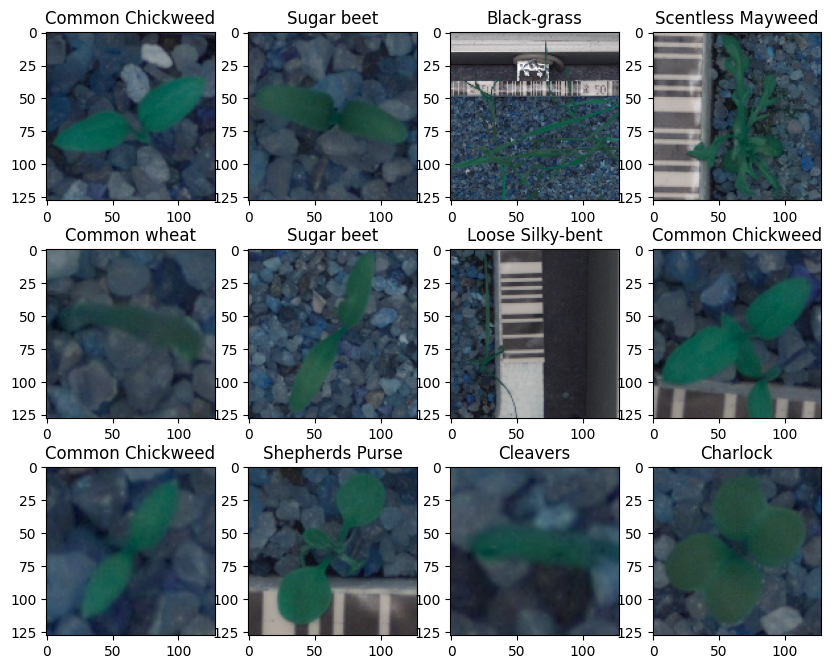

In [7]:
plot_images(images,labels)

Each of the different category plant images are different from each other by the stem size, number of leafs/clovers, size of the leafs, and color.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

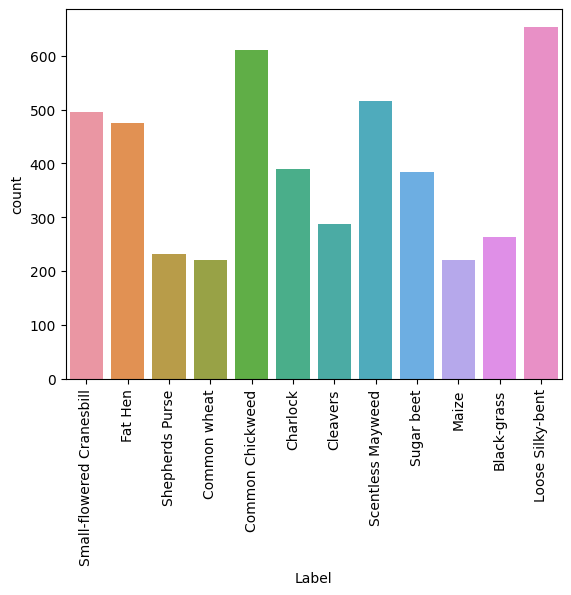

In [8]:
# Checking for data imbalances
sns.countplot(data=labels, x='Label');
plt.xticks(rotation='vertical')



*   As you can see above the data is imbalanced
*   We have about 5 labels above 400 images each, and the rest are below 400 total images



## Data Pre-Processing

### Convert the BGR images to RGB images.

In [9]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

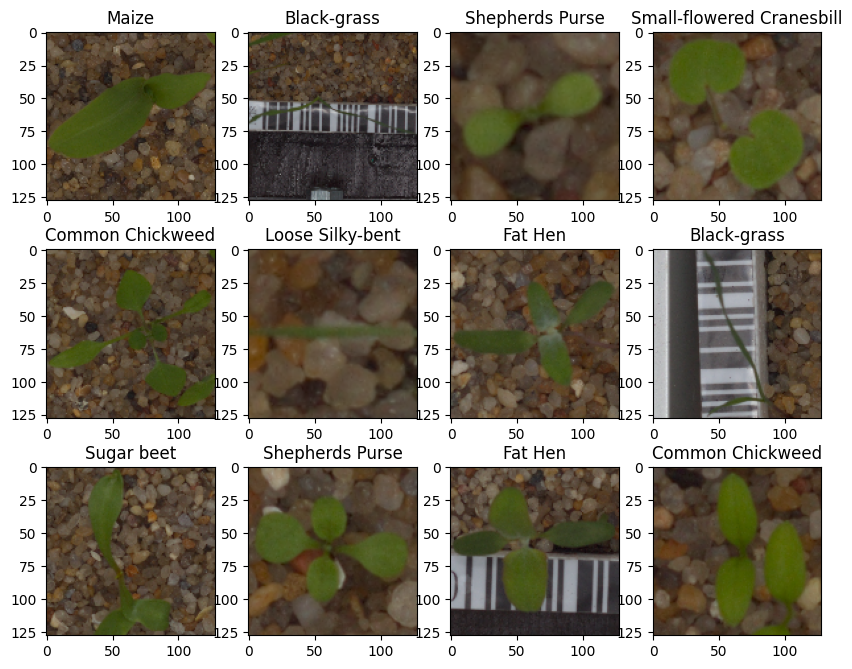

In [10]:
plot_images(images,labels)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [11]:
decreased_images=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  decreased_images.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

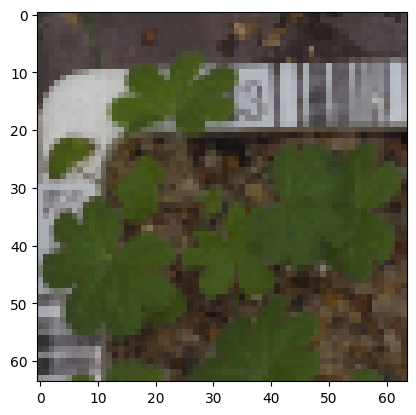

In [12]:
plt.imshow(decreased_images[3])

In [13]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

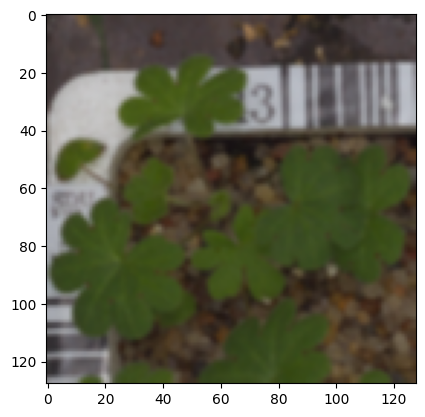

In [14]:
plt.imshow(images_gb[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [15]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(decreased_images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [16]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [17]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [18]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [19]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [20]:
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [21]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(12, activation='softmax'))

opt=Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [22]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 12s - loss: 2.4534 - accuracy: 0.1256 - val_loss: 2.3891 - val_accuracy: 0.1449 - 12s/epoch - 97ms/step
Epoch 2/30
121/121 - 1s - loss: 2.2933 - accuracy: 0.1809 - val_loss: 2.1343 - val_accuracy: 0.2570 - 728ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0976 - accuracy: 0.2485 - val_loss: 1.9386 - val_accuracy: 0.3364 - 704ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9934 - accuracy: 0.2836 - val_loss: 1.8211 - val_accuracy: 0.3435 - 814ms/epoch - 7ms/step
Epoch 5/30
121/121 - 1s - loss: 1.9615 - accuracy: 0.2846 - val_loss: 1.7750 - val_accuracy: 0.3505 - 858ms/epoch - 7ms/step
Epoch 6/30
121/121 - 1s - loss: 1.9351 - accuracy: 0.2898 - val_loss: 1.7617 - val_accuracy: 0.3598 - 819ms/epoch - 7ms/step
Epoch 7/30
121/121 - 1s - loss: 1.9479 - accuracy: 0.2797 - val_loss: 1.7366 - val_accuracy: 0.3692 - 830ms/epoch - 7ms/step
Epoch 8/30
121/121 - 1s - loss: 1.9000 - accuracy: 0.2958 - val_loss: 1.7052 - val_accuracy: 0.3855 - 760ms/epoch - 6ms/step


# Model Evaluation

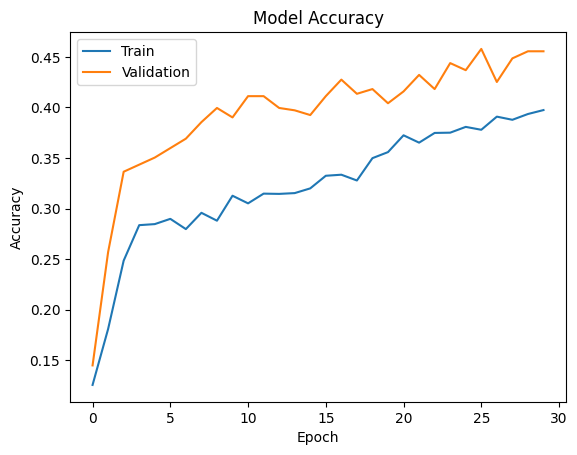

In [23]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* As we can see in the plot above the training accuracy of the model was good, and the validation accuracy was better than the training accuracy.
* The model doesn't appear to be overfitting the data

## Evaluating the model on test data

In [24]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.5610 - accuracy: 0.4716 - 208ms/epoch - 14ms/step


## Generating predictions using the test data

In [25]:
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 5ms/step


In [26]:
y_pred

array([[1.8276136e-13, 1.2441900e-01, 4.3501375e-05, ..., 9.9912949e-02,
        2.0856813e-02, 1.5290901e-04],
       [3.7834226e-07, 2.9970268e-03, 6.7574502e-04, ..., 1.4313527e-02,
        9.7933894e-01, 9.6153782e-04],
       [4.2297702e-06, 5.4484466e-03, 9.1658980e-03, ..., 1.2218983e-02,
        8.9033884e-01, 3.3123098e-02],
       ...,
       [2.5984943e-01, 1.1207640e-04, 2.8048125e-03, ..., 9.4586204e-07,
        2.4666453e-05, 2.1929573e-03],
       [1.5848728e-03, 1.5818089e-01, 5.7366986e-02, ..., 8.6005948e-02,
        3.9368238e-02, 7.7652924e-02],
       [3.1742180e-05, 1.8922436e-01, 3.2019202e-02, ..., 1.3390283e-01,
        1.3006371e-01, 6.3783884e-02]], dtype=float32)

## Plot the confusion matrix

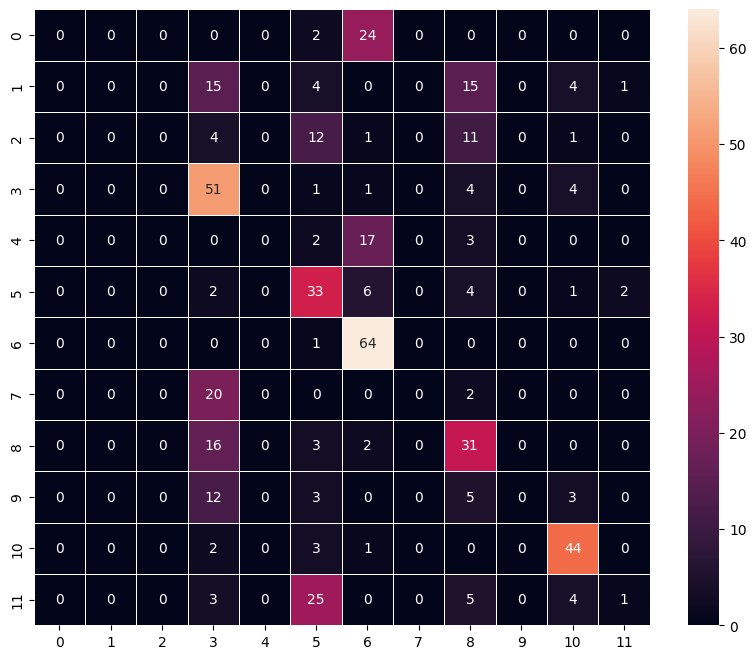

In [27]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* We can observe that some of the classes are not predicted correctly
* In comparison to the rest, we can see that classes 3, 6, 8, and 10 are well classified.
* We can observe that classes 4, 7, and 9 are mostly misclassified

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**. Let's use data augmentation and batch normalization to see if we can improve the model performance.

In [28]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [29]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [33]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
model2.add(Flatten())

model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(12, activation='softmax'))

opt=Adam()

model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

epochs = 30
batch_size = 32

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/30
120/120 [==============================] - 9s 77ms/step - loss: 1.5439 - accuracy: 0.4401 - val_loss: 1.2063 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 5s 38ms/step - loss: 1.5570 - accuracy: 0.4312 - val_loss: 1.2281 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 6s 53ms/step - loss: 1.5275 - accuracy: 0.4453 - val_loss: 1.2430 - val_accuracy: 0.5841 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 5s 37ms/step - loss: 1.5396 - accuracy: 0.4330 - val_loss: 1.2407 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 5s 38ms/step - loss: 1.5266 - accuracy: 0.4404 - val_loss: 1.2764 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 6s 49ms/step - loss: 1.5156 - accuracy: 0.4506 - val_loss: 1.1704 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 7s 55ms/st

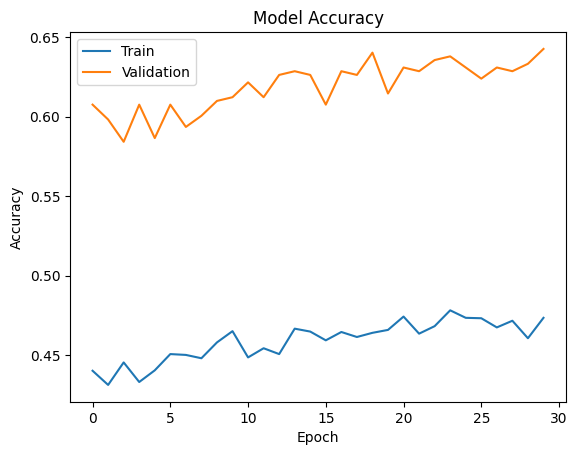

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Our model improvement has shown exceptional results, the accuracy on our validation data has increased substantially compared to the previous model. Batch normalization and data augmentation has approved the model accuracy from 45% to 64% on validation data.

In [39]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1670 - accuracy: 0.6147 - 66ms/epoch - 4ms/step


In [41]:
y_pred_impr=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


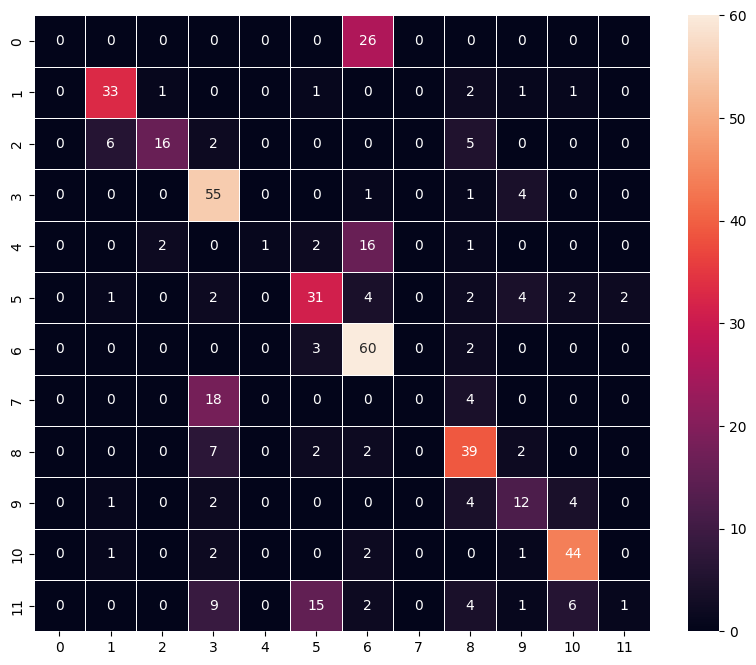

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_impr_arg=np.argmax(y_pred_impr,axis=1)
y_test_impr_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_impr_arg,y_pred_impr_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* The confusion matrix appears to have improved, however there is still some confusion with classes 4, 7, and 11.
* Class 11 is the most confused class of them all
* We can observe that this model has outperformed our previous model substantially

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

I've selected our second model as the final model since its accuracy is far better than our first initial model.

### Visualizing the prediction

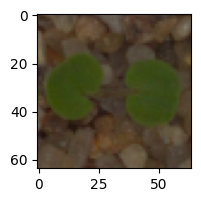

1/1 [==============================] - 0s 188ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


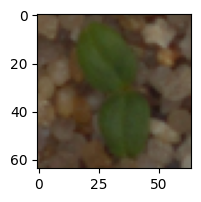

1/1 [==============================] - 0s 48ms/step
Predicted Label ['Scentless Mayweed']
True Label Cleavers


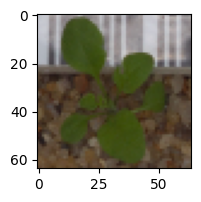

1/1 [==============================] - 0s 72ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [43]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

* We can observe from the confusion matrixes that our second improved model was the best model due to us leveraging batch normalization, data augmentation, and the ReduceLROnPlateau class
* The test accuracy on our final model was 61%
* Data augmentation and batch normalization helped improved our model significantly
* We're able to somewhat accurately classify plant seedlings to their respective classes and there's always room for improvement, but this neural network is a great start for predicting classes for plant seedlings going forward.
* We should deploy our model to create an API endpoint that we can use to start classifying plant seedlings in real-time.  

_____